In [1]:
import pandas as pd
df = pd.read_csv('C:\\Users\\user\\Desktop\\EV\\ElectricVehicleChargingPoints.csv')
print(df.head())

  EV Charger Registration Code               Name  No. of Charging Outlets  \
0                     R115035A  AIRETEC PTE. LTD.                        1   
1                     R115036E  AIRETEC PTE. LTD.                        1   
2                     R115037K  AIRETEC PTE. LTD.                        1   
3                     R115038B  AIRETEC PTE. LTD.                        1   
4                     R115043Z  AIRETEC PTE. LTD.                        1   

   Connector ID Type of Connector  Rated Output Power (kW)  Postal Code  \
0  R115035A-001            Type 2                     22.0        68906   
1  R115036E-001            Type 2                     22.0       159971   
2  R115037K-001            Type 2                     22.0        68906   
3  R115038B-001            Type 2                     22.0       159971   
4  R115043Z-001            Type 2                     22.0       737853   

  Block/House No      Street Name      Building Name Floor No Lot No  \
0       

In [2]:
print(df.shape)  # 看行数和列数
print(df.columns)  # 看有哪些字段

(9384, 15)
Index(['EV Charger Registration Code', 'Name', 'No. of Charging Outlets',
       'Connector ID', 'Type of Connector', 'Rated Output Power (kW)',
       'Postal Code', 'Block/House No', 'Street Name', 'Building Name',
       'Floor No', 'Lot No', 'Is the charger publicly accessible?',
       'Longitude', 'Latitude'],
      dtype='object')


In [3]:
df.groupby('Name')['No. of Charging Outlets'].sum().sort_values(ascending=False)


Name
CHARGE+ PTE. LTD.                                      3290
TOTALENERGIES CHARGING SERVICES SINGAPORE PTE. LTD.    2789
SHELL SINGAPORE PTE. LTD.                              2611
SP MOBILITY PTE. LTD.                                  2418
COMFORTDELGRO ENGIE PTE. LTD.                          1363
STRIDES YTL PTE. LTD.                                   710
VOLT SINGAPORE PTE. LTD.                                410
EIGEN ENERGY PTE. LTD.                                  183
MNL SOLUTIONS PTE. LTD.                                 163
NOVOWATT PTE. LTD.                                      151
EV MOBILITY PTE. LTD.                                   126
FASTPARKNCHARGE PTE. LTD.                                98
EVONE CHARGING PTE. LTD.                                 97
SOLATEKS PTE. LTD.                                       79
KED ENERGY PTE. LTD.                                     63
YINSON EV CHARGE PTE. LTD.                               46
CITY ENERGY GO PTE. LTD.           

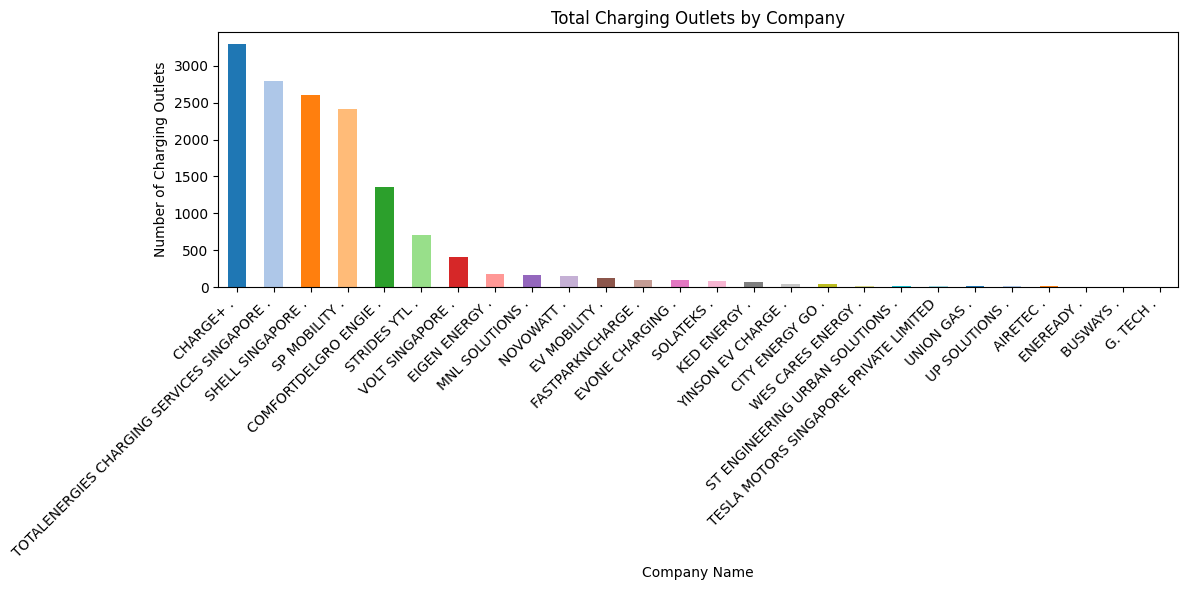

In [4]:
import matplotlib.pyplot as plt
import re

# 清理公司名字：移除常见结尾如 "PTE. LTD", "LTD", "SDN BHD" 等
def clean_company_name(name):
    if isinstance(name, str):
        return re.sub(r'\b(PTE\.?\s*LTD|LTD|SDN\s*BHD)\b', '', name, flags=re.IGNORECASE).strip()
    return name

df['Clean Name'] = df['Name'].apply(clean_company_name)

# 聚合数据
company_chargers = df.groupby('Clean Name')['No. of Charging Outlets'].sum().sort_values(ascending=False)

# 设置颜色：每个柱子一个不同颜色
colors = plt.cm.tab20.colors  # 可选: tab10, Set3, Paired 等
colors = colors * (len(company_chargers) // len(colors) + 1)  # 确保颜色数量足够

# 绘制图形
plt.figure(figsize=(12, 6))
company_chargers.plot(kind='bar', color=colors[:len(company_chargers)])
plt.title('Total Charging Outlets by Company')
plt.xlabel('Company Name')
plt.ylabel('Number of Charging Outlets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


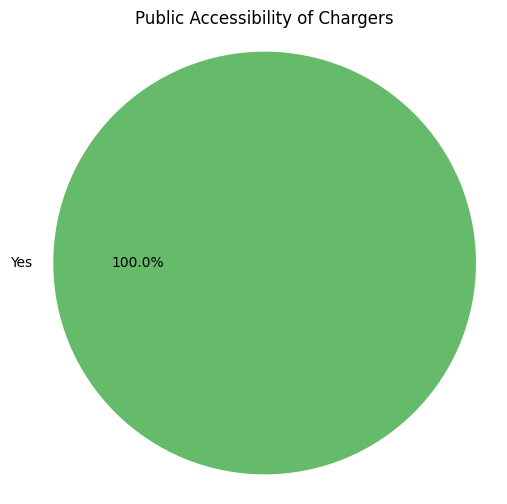

In [5]:
import matplotlib.pyplot as plt

# 统计是否公开数量
public_counts = df['Is the charger publicly accessible?'].value_counts()

# 绘制饼图
plt.figure(figsize=(6, 6))
plt.pie(public_counts, labels=public_counts.index, autopct='%1.1f%%', colors=['#66bb6a', '#ef5350'])
plt.title('Public Accessibility of Chargers')
plt.axis('equal')  # 保持圆形
plt.show()


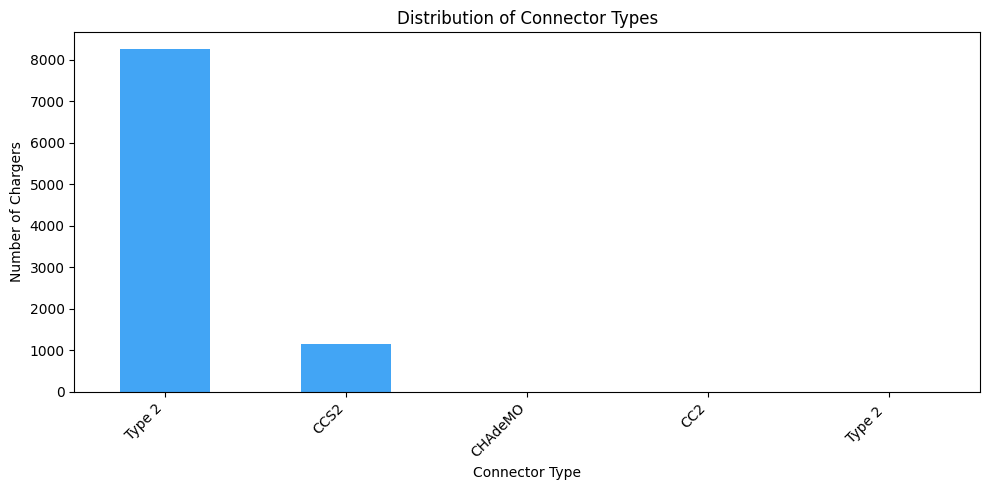

In [6]:
import matplotlib.pyplot as plt

# 统计每种连接器数量
connector_counts = df['Type of Connector'].value_counts()

# 绘制柱状图
plt.figure(figsize=(10, 5))
connector_counts.plot(kind='bar', color='#42a5f5')
plt.title('Distribution of Connector Types')
plt.xlabel('Connector Type')
plt.ylabel('Number of Chargers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [14]:
def classify_charger(power):
    if power >= 22:
        return 'Fast'
    else:
        return 'Slow'

df['Type of Connector'] = df['Rated Output Power (kW)'].apply(classify_charger)


In [15]:
charge_type_summary = df.groupby(['Name', 'Type of Connector'])['No. of Charging Outlets'].sum().unstack().fillna(0)

print(charge_type_summary)


Type of Connector                                     Fast    Slow
Name                                                              
AIRETEC PTE. LTD.                                     11.0     0.0
BUSWAYS PTE. LTD.                                      4.0     0.0
CHARGE+ PTE. LTD.                                    286.0  3004.0
CITY ENERGY GO PTE. LTD.                              37.0     0.0
COMFORTDELGRO ENGIE PTE. LTD.                        455.0   908.0
EIGEN ENERGY PTE. LTD.                               164.0    19.0
ENEREADY PTE. LTD.                                     4.0     1.0
EV MOBILITY PTE. LTD.                                120.0     6.0
EVONE CHARGING PTE. LTD.                              89.0     8.0
FASTPARKNCHARGE PTE. LTD.                             98.0     0.0
G. TECH PTE. LTD.                                      4.0     0.0
KED ENERGY PTE. LTD.                                  61.0     2.0
MNL SOLUTIONS PTE. LTD.                              163.0    

In [16]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from collections import defaultdict
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv(r'C:\Users\user\Desktop\EV\ElectricVehicleChargingPoints.csv')

# 去重
df_unique = df.drop_duplicates(subset=['Latitude', 'Longitude'])

# 获取所有公司名称
companies = df_unique['Name'].unique()

# 为每个公司分配一个颜色（用matplotlib的tab20颜色表）
colors = plt.get_cmap('tab20').colors
company_color_map = {company: f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}' 
                     for company, (r, g, b) in zip(companies, colors * ((len(companies)//20)+1))}

# 创建地图
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=11)

# 每家公司一个图层
company_groups = {}

for _, row in df_unique.iterrows():
    company = row['Name']
    popup_text = f"{row['Name']} ({row['Rated Output Power (kW)']} kW)"
    color = company_color_map.get(company, 'blue')  # 默认灰色

    if company not in company_groups:
        company_groups[company] = folium.FeatureGroup(name=company)
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=popup_text
    ).add_to(company_groups[company])

# 添加图层
for fg in company_groups.values():
    fg.add_to(m)

# 图层控制器
folium.LayerControl(collapsed=False).add_to(m)

# 显示地图（适用于Jupyter）
m


In [17]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# 读取数据
df = pd.read_csv(r'C:\Users\user\Desktop\EV\ElectricVehicleChargingPoints.csv')

# 快/慢充分类
df['Charge Type'] = df['Rated Output Power (kW)'].apply(lambda x: 'Fast' if x >= 22 else 'Slow')

# 去除重复坐标点
df_unique = df.drop_duplicates(subset=['Latitude', 'Longitude'])

# 创建地图
m = folium.Map(location=[1.35, 103.8], zoom_start=11)

# 创建聚合器
marker_cluster = MarkerCluster().add_to(m)

# 加入 CircleMarker
for _, row in df_unique.iterrows():
    popup_text = f"{row['Name']} ({row['Rated Output Power (kW)']} kW)"
    color = 'green' if row['Charge Type'] == 'Fast' else 'blue'

    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=popup_text
    ).add_to(marker_cluster)

# ✅ 在 Jupyter Notebook 中显示地图
m


In [22]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# 生成热力图坐标点
heat_data = df[['Latitude', 'Longitude']].dropna().values.tolist()

# 创建地图（适中缩放，中心自动）
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=11)

# 添加热力图（radius 调小，blur 柔和）
HeatMap(heat_data, radius=8, blur=12, max_zoom=14).add_to(m)

# ✅ 直接在 Jupyter Notebook 中显示地图
m